## NS248 Lecture 4 – Resampling methods (Bootstrap and Permutation tests)

Suggested reading:  Book ch. 10, Jonathan Pillow Lecture 21.

There are also many, many descriptions of these methods online.


Problem: How do we estimate uncertainty when we do not have access to the underlying distribution(s) that generated the data? 

1. Anytime we compute a statistic (mean, median, variance, etc.) we also want to know how sure we are about the value of that statistic.
2. If we are not sure that a Gaussian approximation is a good idea (e.g. the data are complicated) then we want to consider a different approach.


### Bootstrapping:
  Use variability in the data to estimate the variability in the statistic.

Procedure for a single dataset:
1. Start with a dataset of n data points $ X={x_1,x_2,\ldots,x_n} $
2. Choose an $ f(X) $ that you want to calculate (e.g. mean, median, etc.).
3. Randomly sample n points from $ X $ with replacement to get a new set of point $ X_{n_{1}} $
4. Compute $f(X_{n_{1}}) $
5. Repeat 3 & 4 many times (1000s) to get $ \{ f_{1}(X_{n_{1}}), f_{2}(X_{n_{2}}), ... \} $
6. Compute confidence bounds as the (for example) 2.5th and 97.5th percentiles of the distribution of $ f_{i}(X_{n_{i}}) $



#### Python example

Let's start with data from a uniform distribution where we know that the mean should be 0.5:

In [41]:
import numpy as np
import random
n_data_points = 20
data = np.random.uniform(low=0.0, high=1.0, size=n_data_points)
print(f'mean of data: {np.mean(data)}')

mean of data: 0.5044983396940899


We always want to plot our data to make sure it looks reasonable, so we make a quick histogram:

Text(0, 0.5, 'Count')

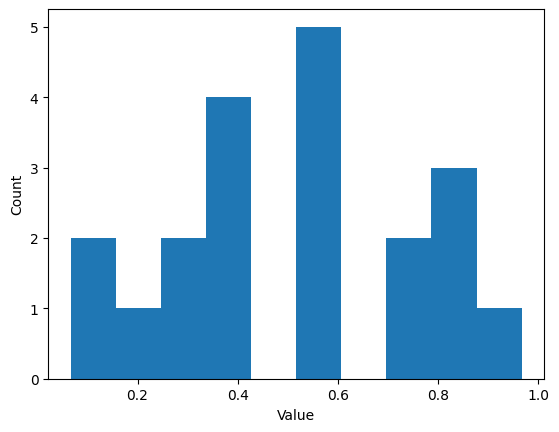

In [42]:
import matplotlib.pyplot as plt
plt.hist(data)
plt.xlabel('Value')
plt.ylabel('Count')

Now we can resample from our data and compute the mean of each set of samples.

Note that python has built in functions for this: `scipy.stats.bootstrap`, but we're going to write out the code to make things clear.

In [43]:
n_boot = 2000
computed_mean = np.zeros(n_boot)
for i in range(n_boot):
    computed_mean[i] = np.mean(random.choices(data, k=n_data_points))

 

Suppose we want the 95% confidence intervals. In that case we need to 
1. Sort the data
2. Find the values corresponding to  2.5% and 97.5% of the distribution

The easiest way to do this is with np.percentile:

In [44]:
confidence_bounds = np.percentile(computed_mean, [2.5, 97.5])
print(f'confidence bounds = {confidence_bounds}')

confidence bounds = [0.39679547 0.61264592]


We can now compare this to what we would get using a standard approach:

In [52]:
import scipy.stats as st
confidence_bounds_sem = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

In [53]:
print(f'confidence bounds from sem = {confidence_bounds_sem}')

confidence bounds from sem = (np.float64(0.38289590717621114), np.float64(0.6261007722119686))


These confidence bounds are quite similar, as we would expect from the central limit theorem.

#### A more interesting example

The confidence bounds on the mean can be calculated fairly accurately using the SEM, so in practice computing bootstrap confidence intervals for the mean is not that useful.

But ... suppose you want to know the confidence bounds for some other statistic, such as the variance of your data. Here it is not obvious how to compute this directly if the data are not Gaussian, but it is easy to do using a bootstrapping approach:

Let's first create a dataset of samples. Here we use a Gaussian distribution to make the data generation simple, but this works for any distribution. 

We can imagine that these are firing rates of neurons in some baseline condition.

In [54]:
mu = 10
sigma = 5 # remember that this means that the variance is 25
n_data_points_var = 50 
A = np.random.normal(loc=mu, scale=sigma, size=n_data_points_var)

Now we can compute the bootstaped set of variances by resampling the data

In [55]:
n_boot = 2000
computed_var = np.zeros(n_boot)
for i in range(n_boot):
    computed_var[i] = np.var(random.choices(A, k=n_data_points_var))

confidence_bounds = np.percentile(computed_var, [2.5, 97.5])
print(f'confidence bounds = {confidence_bounds}')

confidence bounds = [15.89877998 32.23860109]


How would we use confidence bounds like those? Suppose now that we have another set of samples taken from the same system but under a different condition (e.g. we're using optogenetics to inhibit a subclass of interneuron), and we want to ask whether this manipulation changes the variability of the data. For this example we simulate new data with a smaller sigma.

In [56]:
sigma_opto = 4
A_opto = np.random.normal(loc=mu, scale=sigma_opto, size=n_data_points_var)

Now we can compute the variance of our new data and ask whether it is within the confidence bounds of the variance of our baseline data.

In [57]:
var_opto = np.var(A_opto)
print(f'var_opto = {var_opto}, compare to confidence bounds for baseline data: {confidence_bounds}')

var_opto = 13.854533474478178, compare to confidence bounds for baseline data: [15.89877998 32.23860109]


The variance of the new data is outside the confidence bounds for the baseline data, indicating a significant effect of the manipulation. 

#### Using scipy's bootstrap function
The examples below are taken from the scipy API reference.

First we start with a distribution and some samples from it, in this case a normal distriubition:

In [58]:
rng = np.random.default_rng()
from scipy.stats import norm
dist = norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=100, random_state=rng)

Let's suppose that we want to know the standard deviation of the distribution. We'll compare the true value and the value we got for the simulated data. 

In [59]:
std_true = dist.std()      # the true value of the statistic
print(std_true)
std_sample = np.std(data)  # the sample statistic
print(std_sample)

4.0
4.206111900554819


These values are pretty close, but if we don't know the true value, how confident should we be in our measured value?

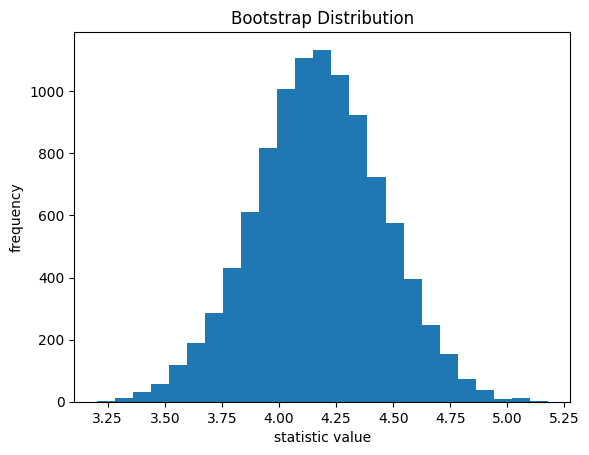

In [60]:
from scipy.stats import bootstrap
if type(data) is not tuple:
    data = (data,)  # samples must be in a sequence
res = bootstrap(data, np.std, confidence_level=0.9, rng=rng)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [61]:
print(f'standard error of bootstrap estimate: {res.standard_error}')
print(f'90% confidence bound of estimate: {res.confidence_interval}')

standard error of bootstrap estimate: 0.2796866239260425
90% confidence bound of estimate: ConfidenceInterval(low=np.float64(3.797293732527974), high=np.float64(4.7306361833437185))


#### Bootstrap comparisons across datasets

We start with a function that returns the statistics we want to compute, in this case a difference in means:

In [102]:
def my_mean(sample1, sample2, axis=-1):
    mean1 = np.mean(sample1, axis=axis)
    mean2 = np.mean(sample2, axis=axis)
    return mean1 - mean2

In [103]:
sample1 = norm.rvs(scale=1, loc=1, size=100, random_state=rng)
sample2 = norm.rvs(scale=1, loc=2, size=100, random_state=rng)
data = (sample1, sample2)
res = bootstrap(data, my_mean, method='basic', rng=rng)
print(f'Actual difference between means: {my_statistic(sample1, sample2)}')
print(f'Confidence Interval: {res.confidence_interval}')

Actual difference between means: -0.6288343293623573
Confidence Interval: ConfidenceInterval(low=np.float64(-0.8977060035475312), high=np.float64(-0.3650094466449071))


It's also possible to use bootstrap with paired data:


In [104]:
from scipy.stats import pearsonr
n = 100
x = np.linspace(0, 10, n)
y = x + rng.uniform(size=n)
print(pearsonr(x, y)[0])  # element 0 is the statistic



0.9949038639471517


In [105]:
def my_pearsonr(x, y, axis=-1):
    return pearsonr(x, y, axis=axis)[0]

res = bootstrap((x, y), my_pearsonr, paired=True, rng=rng)
print(res.confidence_interval)

ConfidenceInterval(low=np.float64(0.9933956429199948), high=np.float64(0.9960103070994201))


#### Limitations of Bootstrapping

Bootstrapping works well in many cases, but can give biased estimates when the number of data points is small (< 20 or so). In general, when the samples are not a great representation of the underlying distribution, estimates based on those samples will be less accurate. 

### Permutation tests

Bootstrapping is useful for estimating confidence bounds. Permutation tests extend this approach to allow us to compare statistics across sets of samples or look at relationships between variables (e.g. measurements of pairs of variables where the goal is to determine whether the two variables are predictive of one another)

Like boostrapping, permutation tests are assumption-free, and thus provide a effective way to ask questions about differences or relationships when the data are non-Gaussian.

Procedure for comparison across groups:
1. Start with two sets of data $ A={a_1,a_2,\ldots,a_n} $ and $ B={b_1,b_2,\ldots,b_m} $. Note that they do not need to contain the same number of points.
2. Choose an $ f(X) $ that you want to compare across the datasets (e.g. means, medians, etc.).
3. Compute $D = f(A) - f(B)$ (the difference of the statistics across the datasets)


4. Create a new set of datasets $ A_{1} $ and $ B_{1} $ by permuting the dataset label (a or b) for each point. One way to think of this is that you make a list that contains both $A$ and $B$ and then draw $n$ points randomly from that list to make a $ A_{1} $, leaving the remaining $m$ points to be 
$ B_{1} $.
5. Compute $ D_{1} = f(A_{1}) - f(B_{1})$ 
6. Repeat 4 & 5 many times (1000s) to get $ \{ D_{1}, D_{2}, ... \} $
7. Lookup the percentile of $D$ within the distribution of $ D_{i} $ and convert to a p-value that estimates the likelihood of getting a value for D that is as extreme or more extreme than your measurement. 

The intuition here is that the permutation of the labels is equivalent to assuming the data all come from the same distribution, allowing us to ask how different the mean of two randome samples of data from that distribution are likely to be. If the difference we measured is larger than we would expect if the data all came from that single distribution, then we have evidence that the two sets of data are different.


In [106]:
# we'll use sample1 and sample2 from above:
from scipy.stats import permutation_test
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = permutation_test((sample1, sample2), my_mean, vectorized=True,
                       n_resamples=10000)
print(f'mean difference between samples: {res.statistic}')
print(f'pvalue: {res.pvalue}')

mean difference between samples: -0.6288343293623573
pvalue: 0.00019998000199980003


#### Python example : differences of means

We will start with a simple two group situation where we simulate data from two Gaussian distributions and ask if we can detect a difference between the means of the samples from those distributions. 

In [182]:
n_data_points_A = 20
n_data_points_B = 15
# define the mu and sigmas for our Gaussians:
mu_a = 10
sigma_a = 5
mu_b = 15
sigma_b = 10

A = np.random.normal(loc=mu_a, scale=sigma_a, size=n_data_points_A)
B = np.random.normal(loc=mu_b, scale=sigma_b, size=n_data_points_B)

In this case we want to compare the means of the distributions, so we calculate the differences in the means.

In [183]:
D = A.mean() - B.mean()

Now we permute the labels and calculate the differences between the permuted means many times. Note that there are functions to do this for you (e.g. `scipy.stats.permutation_test`) but sometimes you will need to write the function yourself because your measure is not a standard one.

In [184]:
n_permute = 10000
# put the data into a single array
pooled_data = np.hstack([A,B])
pooled_D = np.zeros(n_permute)
for i in range(n_permute):
    np.random.shuffle(pooled_data)
    # our new A will be the first n_data_points_A elements
    tmpA = pooled_data[:n_data_points_A]
    # our new B will be the last n_data_points_B. We could of course also do [n_data_points_A+1:]
    tmpB = pooled_data[-n_data_points_B:]
    pooled_D[i] = tmpA.mean() - tmpB.mean()

Now we can determine the percentile of D in the pooled_D distribution

In [1]:
percentile = st.percentileofscore(pooled_D, D)
# to make life easy, if the percentile is > 50, we flip it to be < 50
if percentile > 50:
    percentile = 100 - percentile
print(f'percentile of measured difference is {percentile:0.2f}, corresponding to a two-tailed p-value of {percentile / 100 * 2:0.3f}')

NameError: name 'st' is not defined

In this case the distributions are too similar and the data points too few, to allow us to detect a difference between them.

We can do something very similar if we want to look at measures of the relationship between paired measurements $\{X,Y\}$ such as reaction time and accuracy. In this case we might be interested in determining whether there is a signficant correlation between the measurements, which means that knowing $x$ tells us something about $y$.


Procedure for comparison across groups:
1. Start with a sets of paired data points $ X={x_1,x_2,\ldots,x_n} $ and $ Y={y_1,y_2,\ldots,y_m} $. 
2. Choose an $ f(X,Y) $ that you want to compute.
3. Compute the value of $ f(X,Y) $
4. Create a new set of paired values by keeping $ X $ the same and permuting the order of the points in $ Y $ to create $ \{X, Y_{1}\} $
4. Compute $f_{1} =  f(X,Y_{1}) $ 
5. Repeat 4 & 5 many times (1000s) to get $ \{ f_{1}, f_{2}, ... \} $
6. Lookup the percentile of $f(X,Y)$ within the distribution of $ f_{i} $ and convert to a p-value that estimates the likelihood of getting a value for $f(X,Y)$ that is as extreme or more extreme than your measurement. 

#### Python example: significance of correlation 


In [186]:
n_data_points_XY = 20
# define the mu and sigmas for our X distribution :
mu_x = 10
sigma_x = 10

# for variety, we'll use a log normal distribution for the variabilty of Y around X
mu_y = 1.8
sigma_y = 1.2

# Create a set of simulated X data drawn from a Gaussian distribution
X = np.random.normal(loc=mu_x, scale=sigma_x, size=n_data_points_XY)
# simulate the Y data as uniform variability around the X data
Y = X + np.random.lognormal(mean=mu_y, sigma=sigma_y, size=n_data_points_XY)

Let's plot the data to see what they look like:

Text(0, 0.5, 'Y')

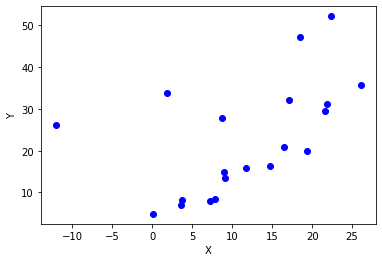

In [187]:
plt.plot(X,Y, 'bo')
plt.xlabel('X')
plt.ylabel('Y')

Now we can compute the correlation from our baseline data set. Note that np.corrcoef returns the full correlation matrix, and we're interested in the off diagonal elements which represent the correlation between X and Y.

In [188]:
corr = np.corrcoef(X,Y)
print(f'correlation = {corr[0,1]}')

correlation = 0.5119619228841004


To determine whether this is a significant correlation, we permute the y labels many times and recompute:

In [189]:
n_permute = 10000
permuted_corr = np.zeros(n_permute)
for i in range(n_permute):
    np.random.shuffle(Y)
    permuted_corr[i] = np.corrcoef(X,Y)[0,1]

In [190]:
percentile = st.percentileofscore(permuted_corr, corr[0,1])
# to make life easy, if the percentile is > 50, we flip it to be < 50
if percentile > 50:
    percentile = 100 - percentile
print(f'percentile of measured difference is {percentile:0.2f}, corresponding to a two-tailed p-value of {(percentile / 100 * 2):.4f}')

percentile of measured difference is 0.96, corresponding to a two-tailed p-value of 0.0192


#### Permutation test general procedure

A permutation test can be used in a wide variety of situations. The general procedure is  
1. Determine what are you trying to test (e.g. differences between groups; relationship between paired data points, etc).
2. Identify a permutation of the data corresponding to your null hypothesis (e.g. the groups come from the same underlying distribution, the paired data points are not related, etc.).
3. Permute the data, recompute the statistic for each permutation, and compare your measured statistics to the distribution of statistics from the permuted data.

### Heirarchical bootstrap for hypothesis testing

see  https://pmc.ncbi.nlm.nih.gov/articles/PMC7906290/ and 
https://github.com/soberlab/Hierarchical-Bootstrap-Paper/blob/master/Bootstrap%20Paper%20Simulation%20Figure%20Codes.ipynb

#### General Idea

When we have multiple levels of nested data, as when we collect data from many cells across multiple animals, we know that the data are not independent within animal. There are two main approaches to deal with this: Linear Mixed Models (to be presented later) and heirarchical bootstrapping.

In the heirarchical bootstrap we create new datasets where we do sampling with replacement at each level. These new datasets allow us to compute differences in our measure across the highest level groups and to get confidence bounds on these differences.